# Introduction

This notebook handles the prediction of all samples from the cloned audio dataset (cloned voices from the TIMIT dataset) and the real audio dataset (Common Voice dataset).

For the prediction, two Azure Machine Learning Pipelines are defined, one for each of both datasets.

Each pipeline has two steps. The first step is just a convenience step for generating a csv file with the names of all audio files that will be predicted. The second step is the actual prediction process, where the trained model checkpoint is downloaded from the corresponding Azure ML Job, and used for the prediction in batches. The results of each batch are saved to a different `.csv` file, and all files will be analyzed later.

The notebook is organized in different sections. The next three sections ([Imports](#Imports), [Utilities](#Utilities), [Setup](#Setup)) are just for setting up all required functions and variables.

The pipeline steps are defined in [Step: Prepare data](#Step:-Prepare-data) and [Step: Predictions](#Step:-Predictions). You will find three parts in each step definition:
    - The Python script: it contains all the logic.
    - A local test: for debugging purposes it is better to test the Python script first in local before executing the Azure ML job.
    - The Azure ML Pipeline Component definition in YAML format: this is the interface to communicate to the Azure ML platform to execute the Python script.
    
Both steps are put together in sequence in the pipeline definitions that can be found in [Pipelines](#Pipelines).

Once these files are defined, you can execute them in [Execute pipelines](#Execute-pipelines).

The results (ROC and ROC AUC) are analyzed in [Result analysis](#Result-analysis).

Finally, there is a [Conclusions](#Conclusions) section with some comments on the results.

# Imports

In [81]:
%load_ext extensions
%cd_repo_root

The extensions extension is already loaded. To reload it, use:
  %reload_ext extensions


'/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchume2/code/Users/rubchume/VoiceCloningFakeAudioDetection'

In [82]:
from contextlib import contextmanager
import importlib
import os
from pathlib import Path
import random
import re
import sys
from typing import Iterable, List

from azure.ai.ml import MLClient
from azureml.core import Workspace, Dataset as AzureCoreDataset, Datastore
from IPython.display import Audio
from azure.identity import DefaultAzureCredential
import mlflow
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from pydub import AudioSegment
import pytorch_lightning as pl
import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

import directory_structure

# Utilities

In [83]:
def reproduce_audio_file_with_pydub(audio_file):
    audio = AudioSegment.from_file(audio_file)
    display(audio)
    

def reproduce_audio_from_pcm_samples(pcm_samples: np.array, sample_rate: int):
    audio = Audio(data=pcm_samples, rate=sample_rate, autoplay=True)
    display(audio)
    

def get_relative_path(origin, destination):
    go_up_path = "../"
    
    origin_absolute = Path(origin).resolve()
    destination_absolute = Path(destination).resolve()
    
    common_path = Path(os.path.commonpath([origin_absolute, destination_absolute]))
    from_origin_to_common_path = Path(go_up_path * (len(origin_absolute.parts) - len(common_path.parts)))
    from_common_path_to_destination = destination_absolute.relative_to(common_path)
    return from_origin_to_common_path / from_common_path_to_destination


@contextmanager
def suppress_error_print():
    original_stderr = sys.stderr
    sys.stderr = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stderr.close()
        sys.stderr = original_stderr


def parse_datastore_uri(datastore_uri):
    match_object = re.match(
        r"^azureml://subscriptions/[^/]+/resourcegroups/[^/]+/workspaces/[^/]+/datastores/(?P<datastore>[^/]+)/paths/(?P<relative_path>.+)$",
        datastore_uri
    )

    datastore_name = match_object.group("datastore")
    relative_path = match_object.group("relative_path")
    return datastore_name, relative_path


def mount_data_asset(data_asset):
    datastore_name, relative_path = parse_datastore_uri(data_asset.path)
    workspace = Workspace.from_config()
    datastore = Datastore.get(workspace, datastore_name)
    dataset = AzureCoreDataset.File.from_files(path=(datastore, relative_path))
    return dataset.mount()
    

@contextmanager
def mounted_data_asset(name, version=None, label="latest"):
    ml_client = MLClient.from_config(credential=DefaultAzureCredential())
    data_asset = ml_client.data.get(name=name, version=version, label=label)
    
    with suppress_error_print():
        mounted_path = mount_data_asset(data_asset)
        mounted_path.start()

    yield mounted_path.mount_point
    mounted_path.stop()

    
import itertools
import runpy


@contextmanager
def cli_arguments(**arguments):
    original_arguments = sys.argv
    sys.argv = kwargs_to_command_line_arguments(**arguments)
    try:
        yield
    finally:
        sys.argv = original_arguments


def kwargs_to_command_line_arguments(**kwargs):
    return [None] + list(itertools.chain.from_iterable([
        (f"--{key}", str(value))
        for key, value in kwargs.items()
    ]))


class WorkingDirectoryOn:
    def __init__(self, working_directory):
        self.working_directory = working_directory
        self.original_working_directory = os.getcwd()
        
    def __enter__(self):
        os.chdir(self.working_directory)
    
    def __exit__(self, exception_type, exception_value, traceback):
        os.chdir(self.original_working_directory)
        
        
@contextmanager
def relative_paths_from(origin, paths):
    yield (
        get_relative_path(origin, path)
        for path in paths
    )
    
    
def import_module(module_file):
    module_path = str(Path(module_file).with_suffix("")).replace("/", ".")
    data_module = importlib.import_module(module_path)
    importlib.reload(data_module)
    return data_module


def logits_to_prob(logits):
    """Convert 2-element logits tensor to probability for 'true' case."""
    probs = F.softmax(torch.Tensor(logits.values), dim=1)
    return probs[:, 1]


def draw_roc(target_values, target_scores, threshold=0.5):
    fpr, tpr, thresholds = torchmetrics.ROC(task="binary")(target_scores, target_values)
    
    index = np.argmin(abs(thresholds - threshold))
    
    return go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr),
            go.Scatter(x=[fpr[index]], y=[tpr[index]], showlegend=False, mode="markers+text", text=f"Threshold = {threshold}", textposition="middle right")
        ],
        layout=dict(
            height=500,
            width=500,
            xaxis_title="False positive rate",
            yaxis_title="True positive rate",
            title="ROC"
        )
    )

# Setup

In [84]:
experiment_name = "classification_wav2vec"

project_source_path = directory_structure.classification_source_path / experiment_name
Path(project_source_path).mkdir(exist_ok=True, parents=True)

pipeline_path = directory_structure.job_definitions_path / experiment_name
Path(pipeline_path).mkdir(exist_ok=True, parents=True)

project_source_path_relative = get_relative_path(pipeline_path, project_source_path)

In [85]:
real_voices_path = directory_structure.data_path / "Common Voice Full/cv-corpus-15.0-2023-09-08/en"
real_voices_info_file = real_voices_path / "selected.csv"

real_info = pd.read_csv(real_voices_info_file).iloc[:, 0].map(
    lambda path: str(real_voices_path / "clips" / path)
)
cloned_info = pd.Series(
    [
        str(path)
        for path in (directory_structure.audio_output_path / "OOTB-YourTTS/TIMITexamples").glob("*.wav")
    ],
    name="path"
)

# Step: Prepare data

## Create scripts

There will be two scripts, one per dataset (one per pipeline).

In [6]:
prepare_common_voice_audio_list_script_name = "prepare_common_voice_audio_list.py"

In [7]:
%%writefile {project_source_path}/{prepare_common_voice_audio_list_script_name}
from pathlib import Path

import pandas as pd

from utils import make_command


@make_command
def main(common_voice_dataset, files_info_tsv, audio_files_csv):
    validated_tsv_path = Path(common_voice_dataset) / files_info_tsv
    pd.read_csv(validated_tsv_path, delimiter="\t").path.to_csv(audio_files_csv, header=False, index=False)
    
    
if __name__ == "__main__":
    main()

Overwriting src/classification/classification_wav2vec/prepare_common_voice_audio_list.py


In [8]:
prepare_timit_cloned_audio_list_script_name = "prepare_timit_cloned_audio_list.py"

In [9]:
%%writefile {project_source_path}/{prepare_timit_cloned_audio_list_script_name}
from pathlib import Path

import pandas as pd

from utils import make_command


@make_command
def main(timit_cloned_dataset, audio_files_csv):
    cloned_info = pd.Series([path.name for path in Path(timit_cloned_dataset).glob("*.wav")]).rename("path")
    cloned_info.to_csv(audio_files_csv, header=False, index=False)
    
    
if __name__ == "__main__":
    main()

Overwriting src/classification/classification_wav2vec/prepare_timit_cloned_audio_list.py


## Test script locally

Uncomment next cells to try in local the previous two scripts.

In order to simulate a scenario as close as possible to the one in the real Azure ML job execution, the Azure Data Assets are mounted (instead of using local files) and the scripts are executed rather than imported.

In [10]:
# sys.modules.pop("prepare_common_voice_audio_list", None)

# ml_client = MLClient.from_config(credential=DefaultAzureCredential())
# common_voice_data_asset = ml_client.data.get(name="CommonVoiceDeltaSegment15", label="latest")

# with mounted_data_asset(common_voice_data_asset) as common_voice_mount_path:
#     with WorkingDirectoryOn(project_source_path):
#         with relative_paths_from(
#             project_source_path,
#             ["temp/selected.csv"]
#         ) as (audio_files_csv,):
#             with cli_arguments(
#                 common_voice_dataset=common_voice_mount_path,
#                 files_info_tsv="en/validated.tsv",
#                 audio_files_csv=audio_files_csv
#             ):
#                 runpy.run_path(prepare_common_voice_audio_list_script_name, run_name='__main__')

In [11]:
# sys.modules.pop(prepare_timit_cloned_audio_list_script_name, None)

# with mounted_data_asset(name="TIMITClonedVoices", label="latest") as timit_cloned_mount_path:
#     with WorkingDirectoryOn(project_source_path):
#         with relative_paths_from(
#             project_source_path,
#             ["temp/timitclonedfiles.csv"]
#         ) as (audio_files_csv,):
#             with cli_arguments(
#                 timit_cloned_dataset=timit_cloned_mount_path,
#                 audio_files_csv=audio_files_csv
#             ):
#                 runpy.run_path(prepare_timit_cloned_audio_list_script_name, run_name='__main__')

## Create component definition

The environment and pipeline components are defined. They simply define an environment similar to the one in local and the execution of the script with command line parameters with names similar to the input arguments of the `main` function of the script.

### Environment

In [12]:
prepare_data_environment_name = "prepare-common-voice-audio-list-environment"

In [13]:
%%rendertemplate {directory_structure.environments_path}/{prepare_data_environment_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: [[prepare_data_environment_name]]
image: mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04
conda_file: conda.yaml
description: Environment created for data preparation in voice classification

'job_definitions/environments/prepare-common-voice-audio-list-environment.yaml'

In [14]:
# !az ml environment create --file {directory_structure.environments_path}/{prepare_data_environment_name}.yaml

### Components

In [15]:
prepare_common_voice_data_component_name = "prepare_common_voice_audio_list.yaml"

In [16]:
%%rendertemplate {pipeline_path}/{prepare_common_voice_data_component_name}
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
type: command

name: prepare_common_voice_data_for_prediction
display_name: Prepare data for prediction

inputs:
    common_voice_dataset:
        type: uri_folder
        mode: ro_mount
    files_info_tsv:
        type: string
    
outputs:
    audio_files_csv:
        type: uri_file
        mode: rw_mount

code: [[project_source_path_relative]]
command: >-
    python [[prepare_common_voice_audio_list_script_name]]
    --common_voice_dataset ${{inputs.common_voice_dataset}}
    --files_info_tsv ${{inputs.files_info_tsv}}
    --audio_files_csv ${{outputs.audio_files_csv}}

environment: azureml:[[prepare_data_environment_name]]@latest

'job_definitions/classification_wav2vec/prepare_common_voice_audio_list.yaml'

In [17]:
prepare_timit_data_component_name = "prepare_timit_audio_list.yaml"

In [18]:
%%rendertemplate {pipeline_path}/{prepare_timit_data_component_name}
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
type: command

name: prepare_timit_data_for_prediction
display_name: Prepare TIMIT data for prediction

inputs:
    timit_dataset:
        type: uri_folder
        mode: ro_mount
    
outputs:
    audio_files_csv:
        type: uri_file
        mode: rw_mount

code: [[project_source_path_relative]]
command: >-
    python [[prepare_timit_cloned_audio_list_script_name]]
    --timit_cloned_dataset ${{inputs.timit_dataset}}
    --audio_files_csv ${{outputs.audio_files_csv}}

environment: azureml:[[prepare_data_environment_name]]@latest

'job_definitions/classification_wav2vec/prepare_timit_audio_list.yaml'

# Step: Predictions

Creation of the prediction step.

## Create script

In this case only one Python script is created and will be used by two pipelines, since the prediction process is the same:

In [19]:
%%writefile {project_source_path}/predict.py
import argparse
import inspect
import itertools
from pathlib import Path
import re
import shutil
import tempfile

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import pandas as pd
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader

from audio_binary_dataset import AudioDumbDataset
from cloned_audio_detector import ClonedAudioDetector
from utils import get_workspace, mounted_datastore, upload_files_to_datastore


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def make_command(function):
    parser = argparse.ArgumentParser()
    for parameter_name, parameter in inspect.signature(function).parameters.items():
        parser.add_argument(f"--{parameter_name}", type=parameter.annotation if parameter.annotation != inspect._empty else None)
    
    def wrapper():
        args, unknown = parser.parse_known_args()
        non_null_args = {key: value for key, value in vars(args).items() if value is not None}
        return function(**non_null_args)
    
    return wrapper


def get_model(job_name, download_path):
    ws = get_workspace()
    ml_client = MLClient(
        credential=DefaultAzureCredential(),
        subscription_id=ws.subscription_id,
        resource_group_name=ws.resource_group,
        workspace_name=ws.name,
    )
    ml_client.jobs.download(
        name=job_name,
        output_name='checkpoint',
        download_path=download_path
    )
    checkpoint_path = Path(download_path) / "named-outputs" / "checkpoint" / "checkpoint"
    detector_loaded = ClonedAudioDetector.load_from_checkpoint(checkpoint_path=checkpoint_path , map_location=device)
    detector_loaded.eval();
    return detector_loaded


def get_file_batch_indices(file):
    match = re.match(r"^logits_batch_(\d+)_(\d+)$", Path(file).stem)
    if match:
        return match.groups()


def predict_macro_batch(
    model,
    dataset,
    predictions_directory,
    batch_size: int = 100,
    macro_batch_size: int = 10,
    overwrite: bool = False
):
    with mounted_datastore(
        datastore_name="workspaceblobstore",
        relative_path=predictions_directory
    ) as predictions_path:
        files = pd.Series(Path(predictions_path).iterdir())
        
    if not overwrite:
        batch_indices = pd.DataFrame(files.map(get_file_batch_indices).dropna().tolist(), columns=["batch_size", "batch_index"]).astype("int")

        batch_indices_of_size = batch_indices[batch_indices.batch_size == batch_size].batch_index
        if len(batch_indices_of_size) > 0:
            last_index = batch_indices_of_size.sort_values(ascending=False).iloc[0]
        else:
            last_index = -1
    else:
        last_index = -1
    
    batch_start_index = last_index + 1
    batch_end_index = batch_start_index + macro_batch_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    iterable = itertools.islice(dataloader, batch_start_index, batch_end_index)

    Path("temp").mkdir(exist_ok=True)
    for batch_index, batch in enumerate(tqdm(iterable, total=macro_batch_size), start=batch_start_index):
        batch_logits = model.forward(batch.to(device))
        pd.DataFrame(batch_logits.cpu().detach().numpy()).to_csv(
            Path("temp") / f"logits_batch_{batch_size}_{batch_index}.csv",
            index=False,
            header=False
        )
        print(f"Batch ({batch_index}/{macro_batch_size}) completed")
    upload_files_to_datastore("workspaceblobstore", predictions_directory, "temp", "*.csv")
    shutil.rmtree("temp", ignore_errors=True)
        

@make_command
def main(job_name, model_download_path, data_path, audio_files_csv, audio_files_folder, predictions_path, batch_size: int = 1000, macro_batch_size: int =100):
    audio_files_folder = Path(data_path) / audio_files_folder
    audio_files_csv = audio_files_csv
    
    audio_files = pd.read_csv(str(audio_files_csv)).iloc[:, 0].map(
        lambda path: str(Path(audio_files_folder) / path)
    )
    
    detector_loaded = get_model(job_name, model_download_path)
    dumb_dataset = AudioDumbDataset(audio_files, 16000, 64000)
    predict_macro_batch(detector_loaded, dumb_dataset, predictions_path, batch_size=batch_size, macro_batch_size=macro_batch_size)

    
if __name__=="__main__":
    main()

Overwriting src/classification/classification_wav2vec/predict.py


## Test script locally

Uncomment next cells to try in local the previous two scripts.

In order to simulate a scenario as close as possible to the one in the real Azure ML job execution, the Azure Data Assets are mounted (instead of using local files) and the scripts are executed rather than imported.

In [20]:
# sys.modules.pop("audio_binary_dataset", None)
# sys.modules.pop("cloned_audio_detector", None)
# sys.modules.pop("utils", None)
# sys.modules.pop("predict", None)

# # predictions_path = directory_structure.training_artifacts_path / "predictions"
# # predictions_path.mkdir(exist_ok=True)
# audio_files_csv = "temp/selected.csv"

# with mounted_data_asset(name="CommonVoiceDeltaSegment15", label="latest") as common_voice_mount_path:
#     with WorkingDirectoryOn(project_source_path):
#         with relative_paths_from(
#             project_source_path,
#             [
#                 # predictions_path,
#                 directory_structure.models_path,
#                 audio_files_csv,
#             ]
#         ) as (
#             # predictions_path_relative,
#             model_download_path,
#             audio_files_csv_relative,
#         ):
#             with cli_arguments(
#                 job_name="dynamic_yacht_mgxs2hytb1",
#                 model_download_path=model_download_path,
#                 data=common_voice_mount_path,
#                 audio_files_csv=audio_files_csv_relative,
#                 audio_files_folder="en/clips/",
#                 predictions_path="Predictions/CommonVoiceDelta15"
#             ):
#                 runpy.run_path(f"predict.py", run_name='__main__')

## Create component definition

The environment and pipeline components are defined. They simply define an environment similar to the one in local and the execution of the script with command line parameters with names similar to the input arguments of the `main` function of the script.

### Environment

In [21]:
predict_environment_name = "predict-environment"

In [22]:
%%rendertemplate {directory_structure.environments_path}/{predict_environment_name}.yaml
$schema: https://azuremlschemas.azureedge.net/latest/environment.schema.json
name: [[predict_environment_name]]
image: mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04
conda_file: conda.yaml
description: Environment created for data preparation in voice classification

'job_definitions/environments/predict-environment.yaml'

In [23]:
# !az ml environment create --file {directory_structure.environments_path}/{predict_environment_name}.yaml

### Component

In [24]:
%%rendertemplate {pipeline_path}/prediction_job.yaml
$schema: https://azuremlschemas.azureedge.net/latest/commandJob.schema.json
name: predict
display_name: Predict audio file type

code: [[project_source_path_relative]]
command: >-
    python predict.py 
    --job_name=${{inputs.job_name}}
    --model_download_path="model"
    --data_path=${{inputs.audio_dataset}}
    --audio_files_csv=${{inputs.files_csv}}
    --audio_files_folder=${{inputs.audio_files_folder}}
    --predictions_path=${{inputs.predictions_path}}
    --batch_size=${{inputs.batch_size}}
    --macro_batch_size=${{inputs.macro_batch_size}}
    --overwrite=${{inputs.overwrite}}

inputs:
    job_name:
        type: string
    audio_dataset:
        type: uri_folder
        mode: ro_mount
    files_csv:
        type: uri_file
        mode: ro_mount
    audio_files_folder:
        type: string
    predictions_path:
        type: string
    batch_size:
        type: integer
    macro_batch_size:
        type: integer
    overwrite:
        type: boolean
        
environment: azureml:[[predict_environment_name]]@latest

'job_definitions/classification_wav2vec/prediction_job.yaml'

# Pipelines

Put previously created step components in sequence by creating the pipeline definitions in YAML format.

## Common Voice

In [25]:
%%rendertemplate {pipeline_path}/prediction_pipeline.yaml
$schema: https://azuremlschemas.azureedge.net/latest/pipelineJob.schema.json
type: pipeline

experiment_name: ClonedVoiceDetectorPrediction
display_name: ClonedVoiceDetectorPrediction
description: Pipeline for cloned voice detection prediction

settings:
    # default_compute: azureml:[[cheap_compute_name]]
    default_compute: azureml:compute-cluster
    
inputs:
    common_voice_dataset:
        type: uri_folder
        path: azureml:CommonVoiceFull4@latest
        mode: ro_mount
    training_job_name: "gray_quince_dz81f9gdyg" #"dynamic_yacht_mgxs2hytb1"
    batch_size: 1000
    macro_batch_size: 1800
    overwrite: true

jobs:
    prepare_audio_files:
        type: command
        component: [[prepare_common_voice_data_component_name]]
        inputs:
            common_voice_dataset: ${{parent.inputs.common_voice_dataset}}
            files_info_tsv: "validated.tsv"
        outputs:
            audio_files_csv:
                mode: upload
    predict:
        type: command
        component: prediction_job.yaml
        inputs:
            job_name: ${{parent.inputs.training_job_name}}
            audio_dataset: ${{parent.inputs.common_voice_dataset}}
            files_csv: ${{parent.jobs.prepare_audio_files.outputs.audio_files_csv}}
            audio_files_folder: "clips/"
            predictions_path: "Predictions/CommonVoiceFull"
            batch_size: ${{parent.inputs.batch_size}}
            macro_batch_size: ${{parent.inputs.macro_batch_size}}
            overwrite: ${{parent.inputs.overwrite}}

'job_definitions/classification_wav2vec/prediction_pipeline.yaml'

## TIMIT cloned

In [26]:
%%rendertemplate {pipeline_path}/prediction_pipeline_cloned.yaml
$schema: https://azuremlschemas.azureedge.net/latest/pipelineJob.schema.json
type: pipeline

experiment_name: ClonedVoiceDetectorPrediction
display_name: ClonedVoiceDetectorPrediction
description: Pipeline for cloned voice detection prediction

settings:
    # default_compute: azureml:[[cheap_compute_name]]
    default_compute: azureml:compute-cluster
    
inputs:
    cloned_voice_dataset:
        type: uri_folder
        path: azureml:TIMITClonedVoices@latest
        mode: ro_mount
    training_job_name: "gray_quince_dz81f9gdyg" # "dynamic_yacht_mgxs2hytb1"
    batch_size: 1000
    macro_batch_size: 100
    overwrite: true

jobs:              
    prepare_audio_files_cloned:
        type: command
        component: [[prepare_timit_data_component_name]]
        inputs:
            timit_dataset: ${{parent.inputs.cloned_voice_dataset}}
        outputs:
            audio_files_csv:
                mode: upload
            
    predict_cloned:
        type: command
        component: prediction_job.yaml
        inputs:
            job_name: ${{parent.inputs.training_job_name}}
            audio_dataset: ${{parent.inputs.cloned_voice_dataset}}
            files_csv: ${{parent.jobs.prepare_audio_files_cloned.outputs.audio_files_csv}}
            audio_files_folder: "."
            predictions_path: "Predictions/TIMITcloned"
            batch_size: ${{parent.inputs.batch_size}}
            macro_batch_size: ${{parent.inputs.macro_batch_size}}
            overwrite: ${{parent.inputs.overwrite}}

'job_definitions/classification_wav2vec/prediction_pipeline_cloned.yaml'

# Execute pipelines

In [28]:
!az ml job create --file {pipeline_path}/prediction_pipeline.yaml

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
{
  "creation_context": {
    "created

In [27]:
!az ml job create --file {pipeline_path}/prediction_pipeline_cloned.yaml

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading classification_wav2vec (0.03

# Result analysis

Read predictions

In [54]:
with utils.mounted_datastore(
    datastore_name="workspaceblobstore",
    relative_path="Predictions/CommonVoiceFull"
) as predictions_path:
    real_predictions_files = pd.Series(Path(predictions_path).iterdir())
    results_real = pd.concat([
        pd.read_csv(file, header=None)
        for file in real_predictions_files[real_predictions_files.map(str).str.endswith(".csv")]
    ], axis="index").reset_index(drop=True).set_axis(["logits_0", "logits_1"], axis="columns")

with utils.mounted_datastore(
    datastore_name="workspaceblobstore",
    relative_path="Predictions/TIMITcloned"
) as predictions_path:
    cloned_predictions_files = pd.Series(Path(predictions_path).iterdir())
    results_cloned = pd.concat([
        pd.read_csv(file, header=None)
        for file in cloned_predictions_files[cloned_predictions_files.map(str).str.endswith(".csv")]
    ], axis="index").reset_index(drop=True).set_axis(["logits_0", "logits_1"], axis="columns")

Message: Running rslex direct volume mount: RSLEX_DIRECT_VOLUME_MOUNT=None, RSLEX_DIRECT_VOLUME_WRITABLE_MOUNT=None, enable_rslex_mount=None
Payload: {"pid": 4096, "source": "azureml.dataprep", "version": "4.12.1", "trace": "azureml|data|dataset_error_handling.py, line 66 in function _validate_has_data.\nazureml|data|dataset_factory.py, line 922 in function from_files.\nazureml|data|_loggerfactory.py, line 132 in function wrapper.", "subscription": "", "run_id": "", "resource_group": "", "workspace_name": "", "experiment_id": "", "location": "", "rslex_version": "2.19.2"}


Convert logits to probabilities

In [80]:
cloned_scores = logits_to_prob(results_cloned)
real_scores = logits_to_prob(results_real)

Calculate ROC and ROC AUC

In [ ]:
scores = pd.concat([pd.Series(real_scores), pd.Series(cloned_scores)])
cloned = pd.Series([0] * len(real_scores), [1] * len(cloned_scores))
AUC = torchmetrics.AUROC(task="binary")(scores, cloned)
fig = draw_roc(cloned, scores, threshold=0.5)
fig.update_layout(dict(title=f"AUC = {AUC}"))

# Conclusions

The audio classification task has been a success. The generalization capability of the model is hence very good.

Nonetheless, the reason why the training rapidly converged to such good performance can be due to big differences between the synthetically created voices and the real audios. These differences might be subtle for the human eye, but obvious for the CNN based neural network that was used as a model.

By inspecting the spectograms we don't find any obvious differences:

In [86]:
module_file_relative_path = project_source_path / "audio_binary_dataset.py"
dataset = import_module(module_file_relative_path)

In [87]:
real_voices_path = directory_structure.data_path / "CommonVoiceFull3Try/cv-corpus-15.0-2023-09-08/en"
real_voices_info_file = real_voices_path / "validated.tsv"

real_info = pd.read_csv(real_voices_info_file, delimiter="\t").path.map(
    lambda path: str(real_voices_path / "clips" / path)
)

In [121]:
dumb_dataset_real = dataset.AudioDumbDataset(real_info, 16000, 32000)

In [100]:
# from itertools import islice

# from tqdm.notebook import tqdm

# batch_size = 60000
# start_index = 0
# end_index = start_index + batch_size

# maxims = []
# minims = []
# for spectogram in tqdm(islice(dumb_dataset, start_index, end_index), total=batch_size):
#     if torch.any(torch.isinf(spectogram)):
#         raise ValueError("Inf value")
        
#     if torch.any(torch.isnan(spectogram)):
#         raise ValueError("Nan value")
        
#     maxims.append(torch.max(spectogram))
#     minims.append(torch.min(spectogram))
#     # if torch.max(torch.abs(spectogram)) > 1:
#     #     raise ValueError("Max abs bigger than 1")
        

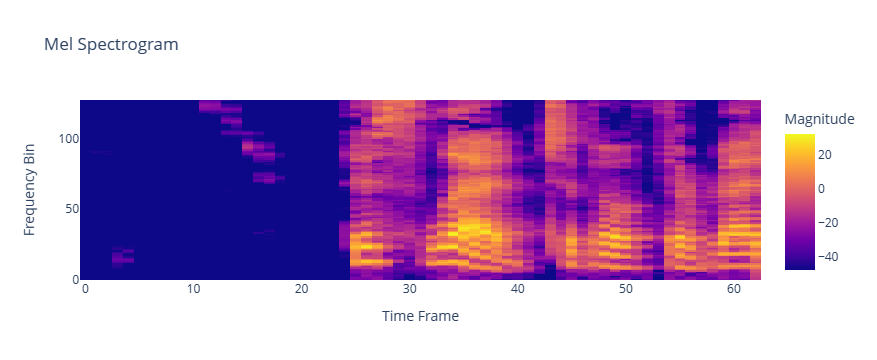

In [145]:
import plotly.express as px
import numpy as np
import torch


# Plot using Plotly
fig = px.imshow(dumb_dataset_real[15].squeeze().numpy(), origin='lower', aspect='auto',
                labels=dict(x="Time Frame", y="Frequency Bin", color="Magnitude"),
                title="Mel Spectrogram")
fig.show()


In [123]:
dumb_dataset_cloned = dataset.AudioDumbDataset(cloned_info, 16000, 32000)

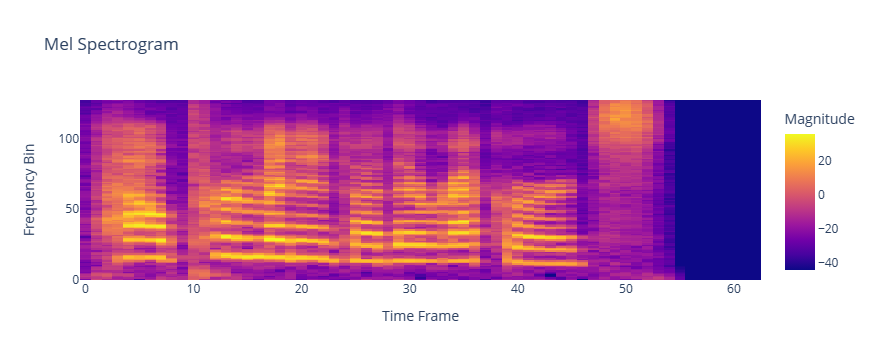

In [130]:
import plotly.express as px
import numpy as np
import torch


fig = px.imshow(dumb_dataset_cloned[0].squeeze().numpy(), origin='lower', aspect='auto',
                labels=dict(x="Time Frame", y="Frequency Bin", color="Magnitude"),
                title="Mel Spectrogram")
fig.show()